# Cleaning and Analyzing Geographic Data
- Download the station data from the OpenAQ Api.
- Merge with district and state data **from 2011 census**.
    - This is the latest time for which we have religion data by districts.
- Merge with pollution data and analyze relationship between census demographics and diwali polution levels.

In [ ]:
pip install shapely

In [ ]:
# loading packages
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import openaq
import warnings
import plotly.express as pxxn
import geopandas as gpd
from shapely.geometry import Polygon, MultiPolygon, shape, Point
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import shapely
from linearmodels import PanelOLS

warnings.simplefilter('ignore')
%matplotlib inline
sns.set("notebook", style='ticks', font_scale=1.0)
mpl.rcParams['figure.dpi']= 300
api = openaq.OpenAQ()

## Cleaning and Analyzing API Station Data

In [ ]:
# getting data for each station in India from OpenAQ
locs = api.locations(limit=100000, df=True, country="IN").reset_index()
print(str(locs.shape[0]) + " stations in India:")
locs.head()

554 stations in India:


,index,id,country,city,cities,location,locations,sourceName,sourceNames,sourceType,sourceTypes,firstUpdated,lastUpdated,parameters,countsByMeasurement,count,coordinates.latitude,coordinates.longitude
0,0,5541,IN,Delhi,[Delhi],"Burari Crossing, Delhi - IMD","[Burari Crossing, Delhi - IMD, Burari Crossing...",caaqm,"[caaqm, data.gov.in]",government,[government],2018-03-09 05:30:00+00:00,2022-01-11 17:00:00+00:00,"[o3, no2, co, pm25, pm10]","[{'parameter': 'o3', 'count': 46541}, {'parame...",225051,28.725650,77.201157
1,1,5565,IN,Chandrapur,"[Chandrapur, \nKhutala]","MIDC Khutala, Chandrapur - MPCB","[MIDC Khutala, Chandrapur - MPCB]",caaqm,"[caaqm, data.gov.in]",government,[government],2018-03-09 05:30:00+00:00,2022-01-11 17:00:00+00:00,"[so2, pm25, no2, o3, co, pm10]","[{'parameter': 'so2', 'count': 104950}, {'para...",608682,19.977530,79.233709
2,2,5570,IN,Delhi,[Delhi],"Aya Nagar, Delhi - IMD","[Aya Nagar, Delhi - IMD, Aya Nagar, New Delhi ...",caaqm,"[caaqm, data.gov.in]",government,[government],2018-03-09 05:30:00+00:00,2022-01-11 17:00:00+00:00,"[no2, o3, pm25, co, pm10]","[{'parameter': 'no2', 'count': 106409}, {'para...",525590,28.470691,77.109936
3,3,5592,IN,Nashik,"[Gangapur Road, Nashik]","Gangapur Road, Nashik - MPCB","[Gangapur Road, Nashik - MPCB]",caaqm,"[caaqm, data.gov.in]",government,[government],2018-03-09 05:30:00+00:00,2022-01-11 17:00:00+00:00,"[o3, pm10, pm25, co, no2, so2]","[{'parameter': 'o3', 'count': 119378}, {'param...",717062,20.007328,73.776243
4,4,5593,IN,Thane,"[Thane, Tiwani Chawl]","Pimpleshwar Mandir, Thane - MPCB","[Pimpleshwar Mandir, Thane - MPCB]",caaqm,"[caaqm, data.gov.in]",government,[government],2018-03-09 05:30:00+00:00,2022-01-11 17:00:00+00:00,"[no2, co, so2, pm25, o3, pm10]","[{'parameter': 'no2', 'count': 106331}, {'para...",553610,19.192056,72.958519


In [ ]:
# adding columns
locs["firstYear"] = locs["firstUpdated"].dt.strftime("%Y").astype(int)
locs["start_date_months_after_jan_2016"] = locs["firstUpdated"].dt.strftime("%m").astype(int)
locs["start_date_months_after_jan_2016"] += 12 * (locs["firstYear"] - 2016)

locs["lastYear"] = locs["lastUpdated"].dt.strftime("%Y").astype(int)
locs["end_date_months_after_jan_2016"] = locs["lastUpdated"].dt.strftime("%m").astype(int)
locs["end_date_months_after_jan_2016"] += 12 * (locs["lastYear"] - 2016)

In [ ]:
# saving relevant locs as a csv
#locs[["id", "location", "city"]].to_csv("relevant_locs.csv", index=False)

In [ ]:
# We want stations with data for Diwali 2020 and at least one other "control" year.
# That is, they should start on or before October 2019 and end on or after November 2020.
locs = locs[locs["end_date_months_after_jan_2016"] >= 12 * 4 + 11]
locs = locs[locs["start_date_months_after_jan_2016"] <= 12 * 3 + 10]
print("This reduces our number of stations to " + str(locs.shape[0]))

This reduces our number of stations to 191


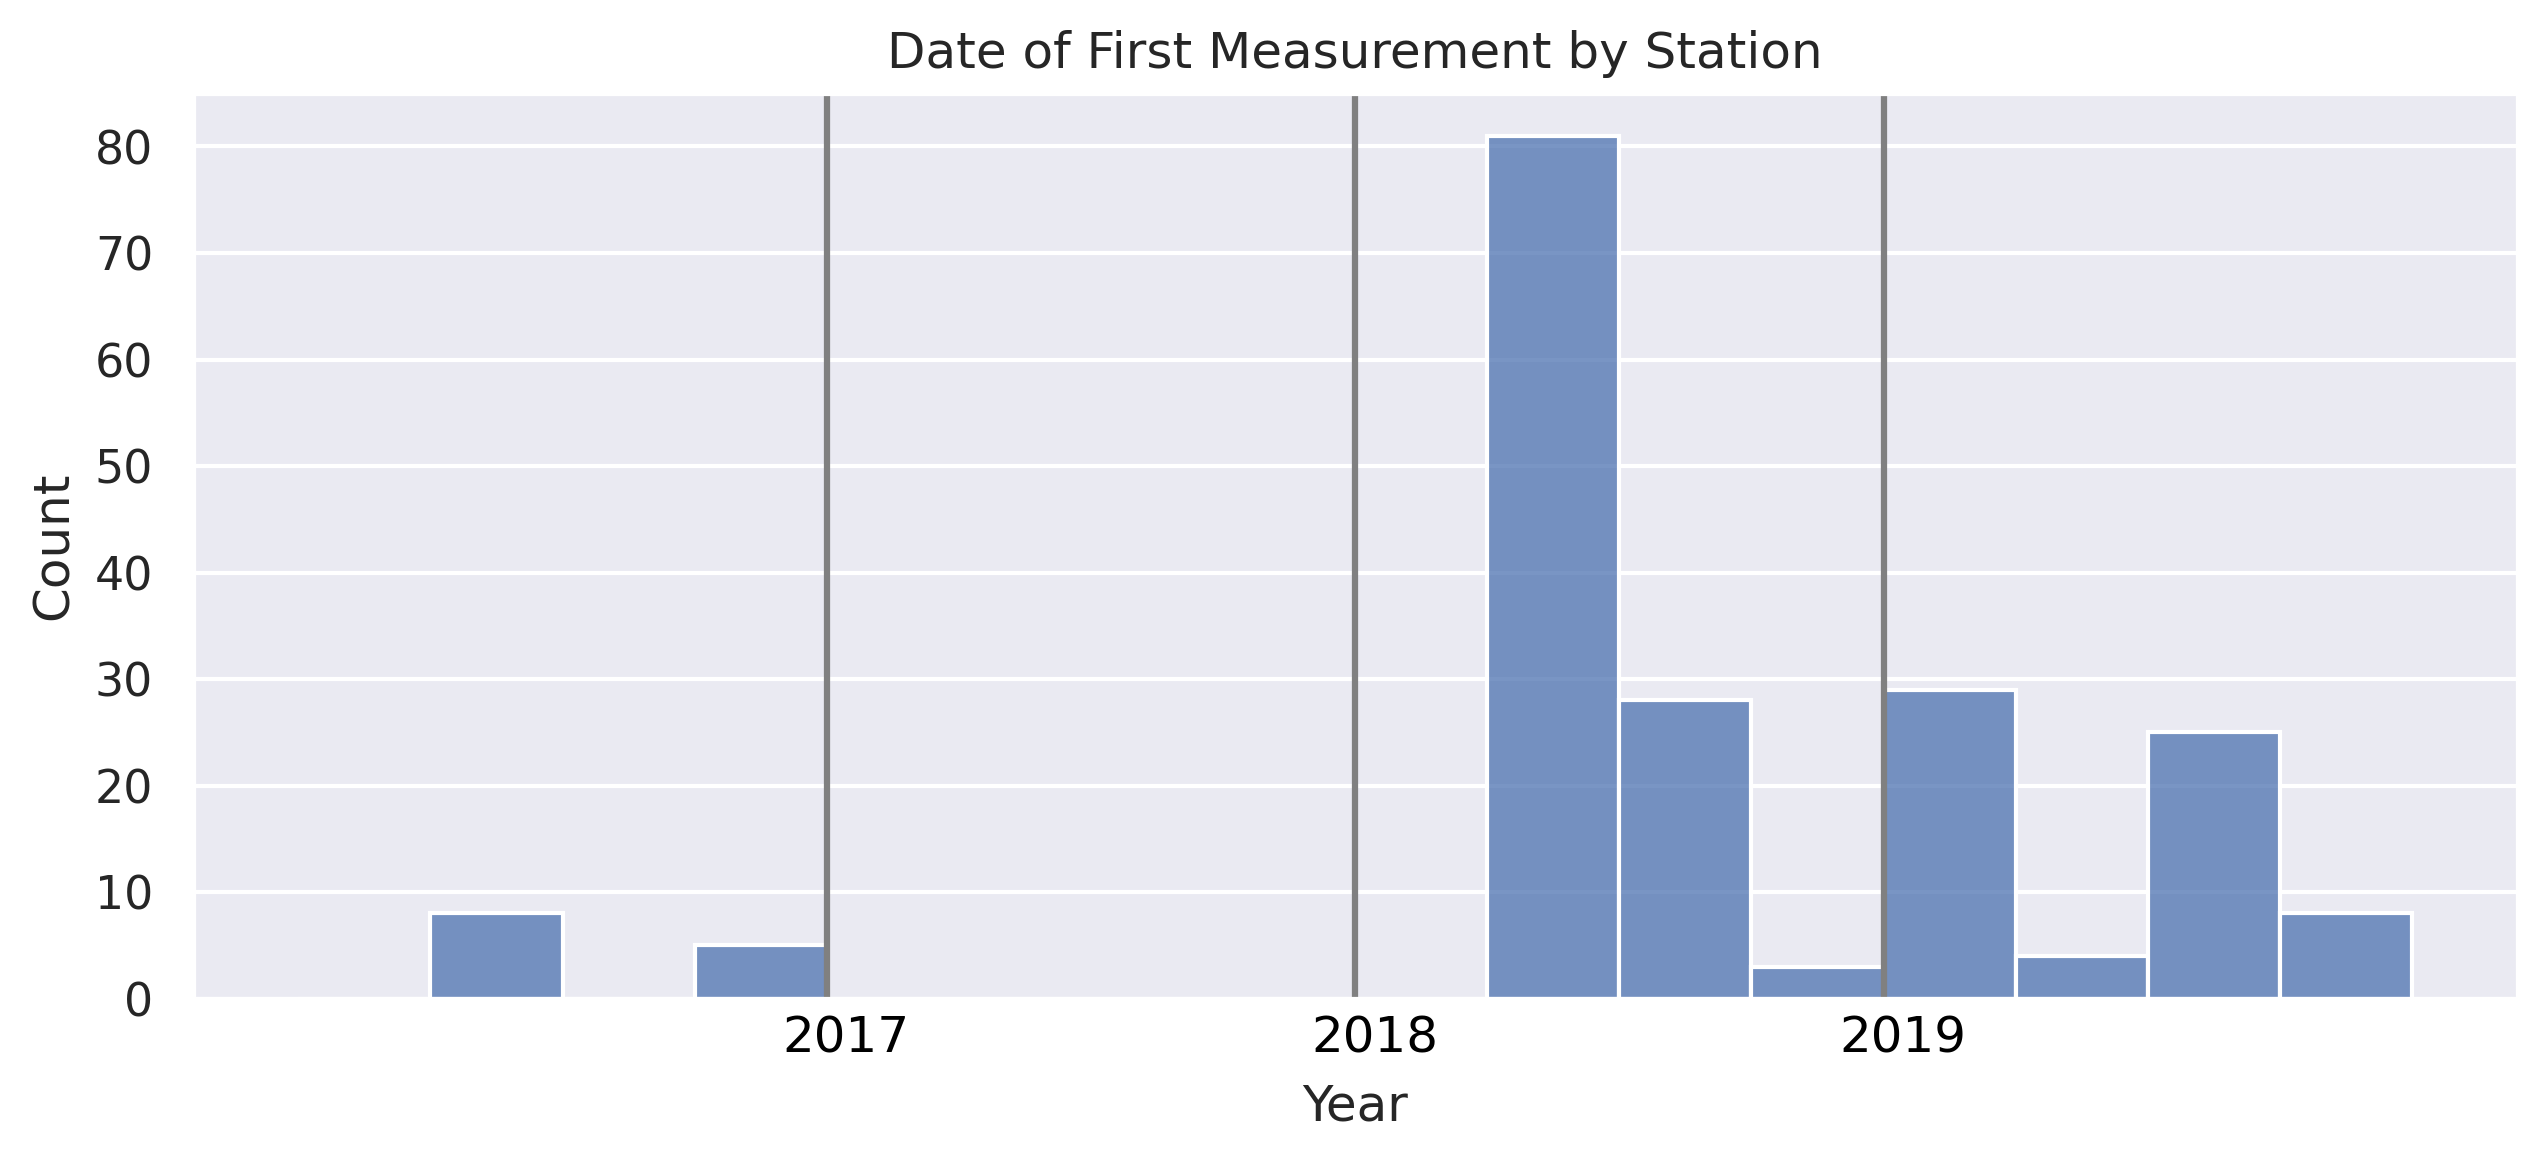

In [ ]:
# we can now plot the start dates of stations
sns.set(rc={'figure.figsize':(10,4)})
ax = sns.histplot(data=locs, x="start_date_months_after_jan_2016", binwidth=3,
                 binrange=[0, 48])
plt.axvline(12, color="grey")
plt.text(11,-5,'2017',color="black")
plt.axvline(24, color="grey")
plt.text(23,-5,'2018',color="black")
plt.axvline(36, color="grey")
plt.text(35,-5,'2019',color="black")
plt.xlabel("Year", labelpad=20)
plt.xticks([])
plt.title("Date of First Measurement by Station")
plt.show()

In [ ]:
print(locs['sourceType'].value_counts())
print("All stations are owned by the government.")

government    191
Name: sourceType, dtype: int64
All stations are owned by the government.


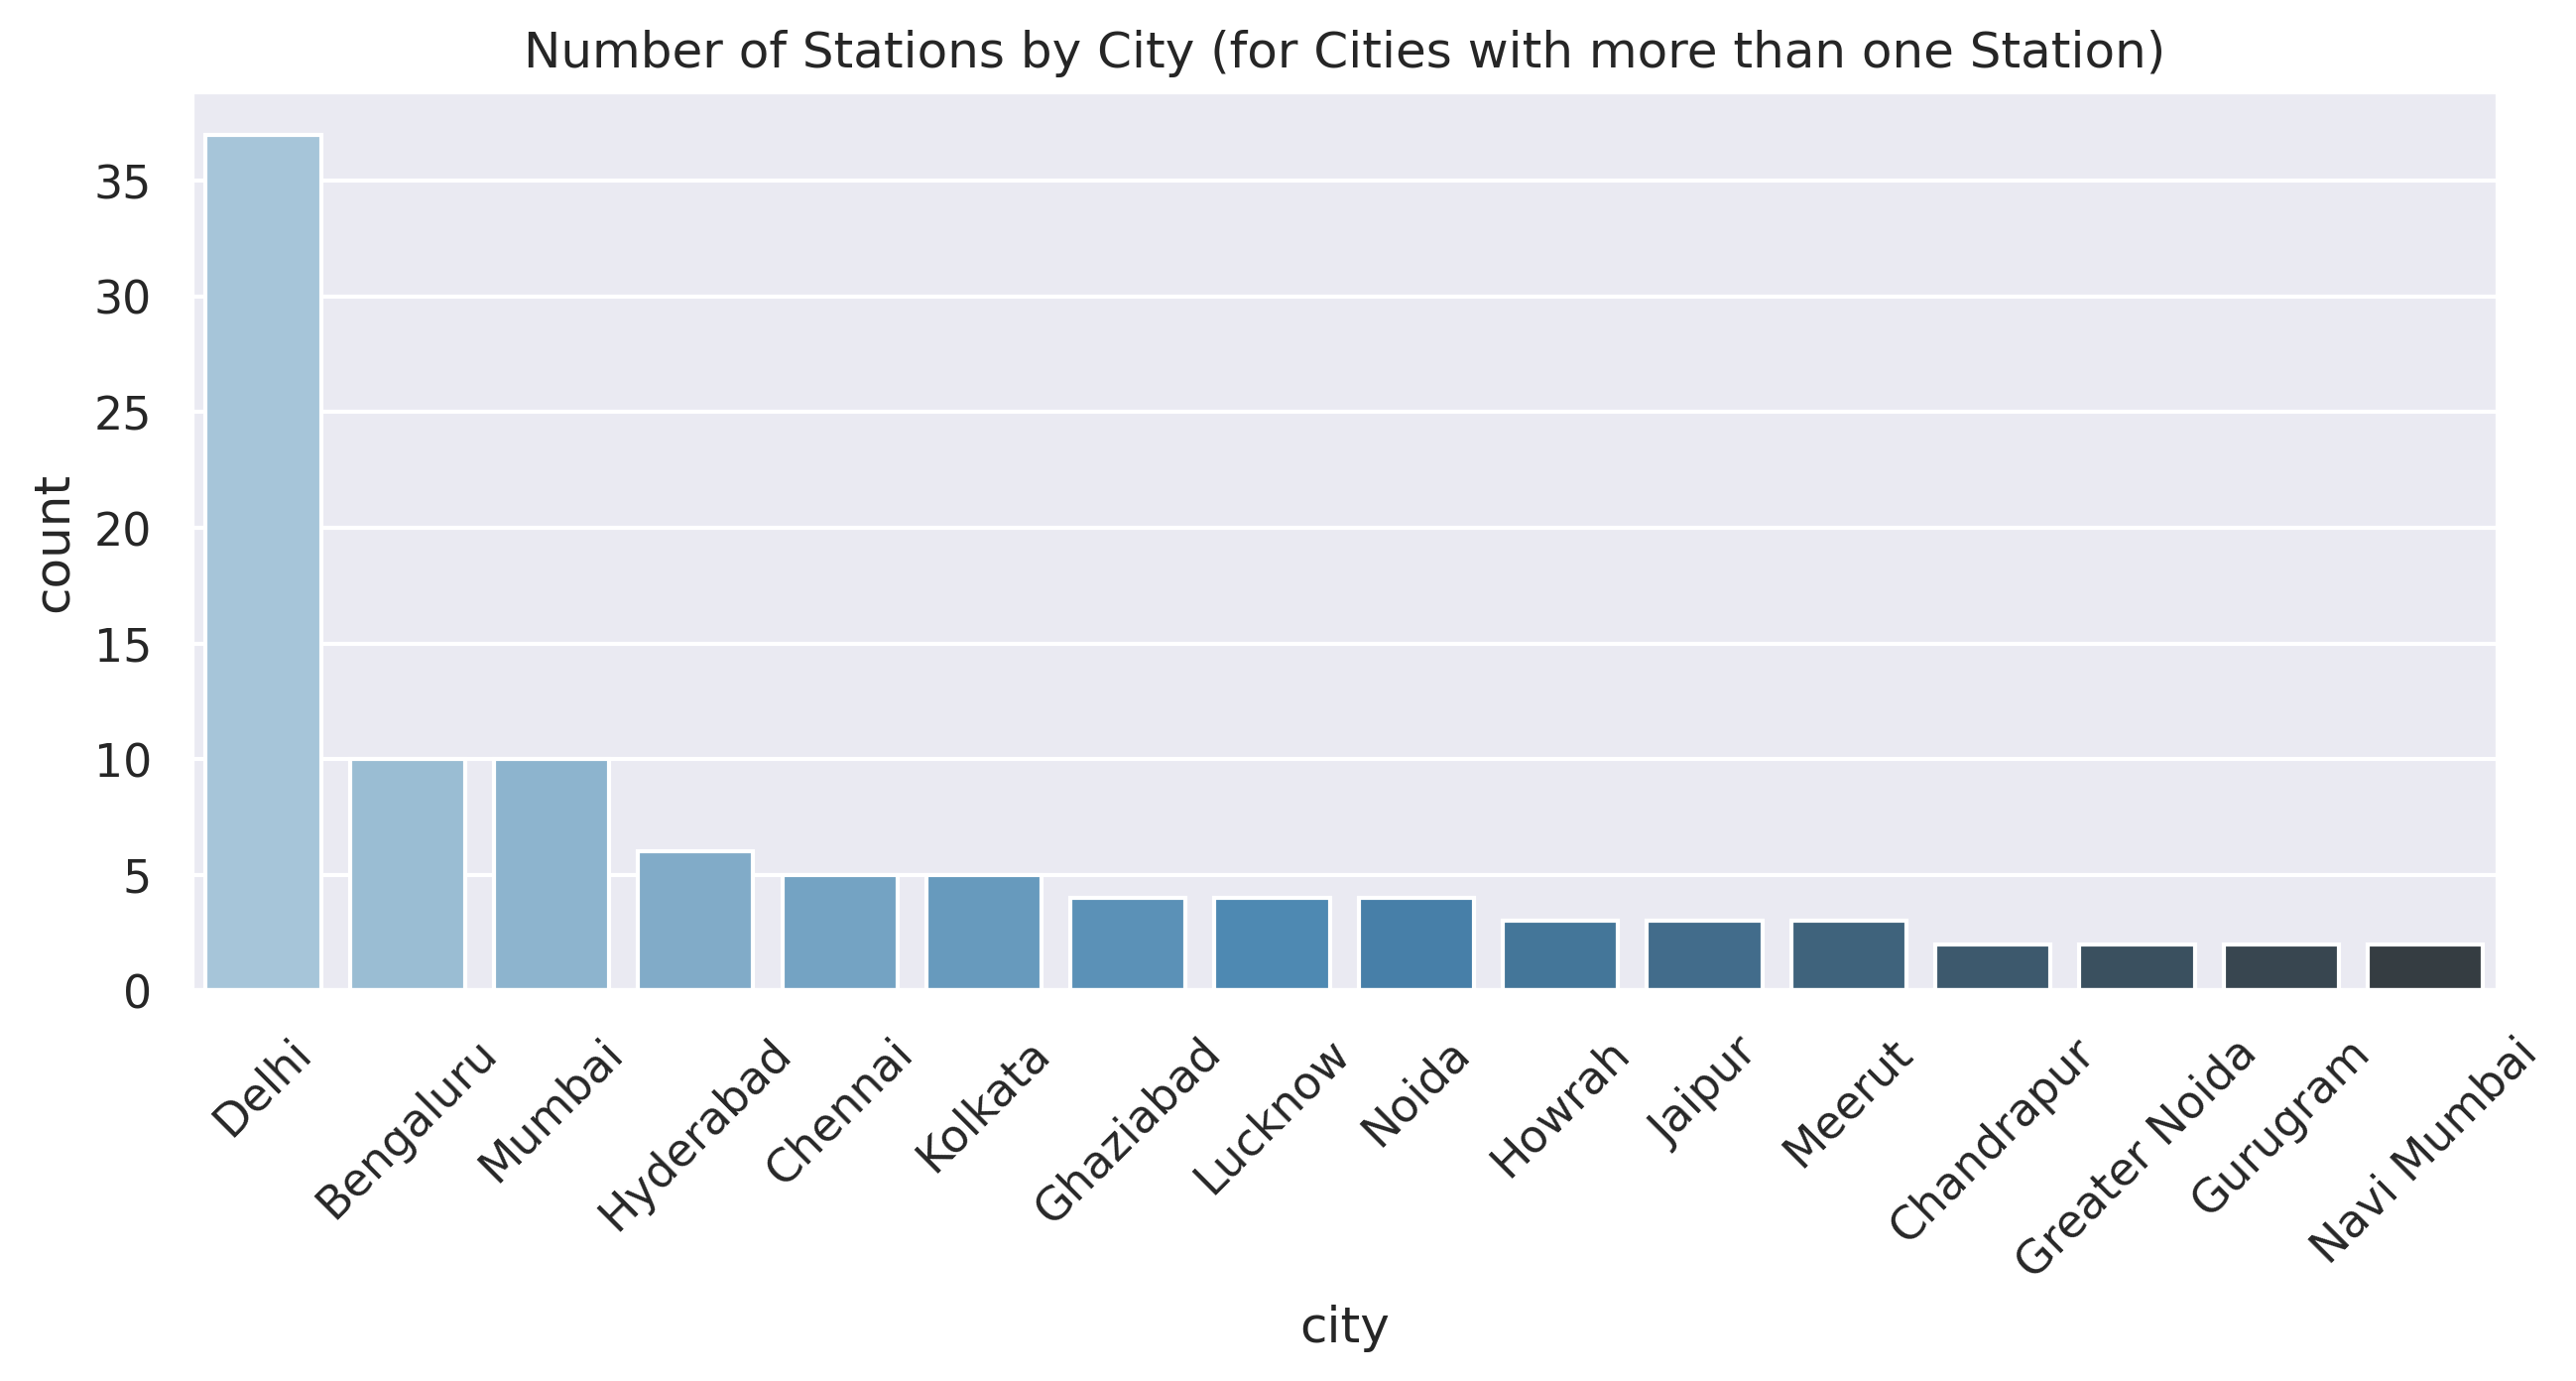

105 total cities.


In [ ]:
city_counts = locs[['city', 'country']].groupby("city").count().reset_index()
city_counts.columns = ["City", "Number of Stations"]
cities = list(city_counts[city_counts["Number of Stations"] > 1].sort_values("Number of Stations",
                                                            ascending=False)["City"])
sns.countplot(x='city', data=locs[locs["city"].isin(cities)], palette="Blues_d",
             order=cities)
plt.xticks(rotation=45)
plt.title("Number of Stations by City (for Cities with more than one Station)")
plt.show()

print(str(len(locs["city"].unique())) + " total cities.")

## Merging with Geographical Data

In [ ]:
def convert_3D_2D(geometry):
    '''
    Takes a GeoSeries of 3D Multi/Polygons (has_z) and returns a list of 2D 
    Multi/Polygons
    '''
    new_geo = []
    for p in geometry:
        if p.has_z:
            if p.geom_type == 'Polygon':
                lines = [xy[:2] for xy in list(p.exterior.coords)]
                new_p = Polygon(lines)
                new_geo.append(new_p)
            elif p.geom_type == 'MultiPolygon':
                new_multi_p = []
                for ap in p:
                    lines = [xy[:2] for xy in list(ap.exterior.coords)]
                    new_p = Polygon(lines)
                    new_multi_p.append(new_p)
                new_geo.append(MultiPolygon(new_multi_p))
    return new_geo

In [ ]:
def change_name(name):
    """
    changing names of states to link datasets
    """
    if name == "karnatka":
        return "karnataka"
    elif name == 'tamilnadu':
        return "tamil nadu"
    elif name == 'dadra & nagar haveli':
        return 'dadra and nagar haveli'
    elif name == "pondicherry":
        return "puducherry"
    return name

In [ ]:
def multi_to_polygon(m, j):
    """
    returns the jth polygon in multypolygon m
    """
    try:
        return list(m)[j]
    except:
        return m
    
def multi_len(m):
    """
    returns the length of a multypolygon m
    """
    try:
        return len(list(m))
    except:
        return 1

In [ ]:
#loading data
districts = gpd.read_file("/Users/calamos/Desktop/Diwali Paper/data/india_districts.json")
states = gpd.read_file("/Users/calamos/Desktop/Diwali Paper/data/india_states.json")

# cleaning data
districts = districts[["nam", "laa", "geometry"]]
districts["laa"] = districts["laa"].str.lower()
districts["nam"] = districts["nam"].str.lower()
districts.columns = ["state", "district", "geometry"]
districts["state"] = districts["state"].apply(change_name)

states = states[["NAME_1", "geometry"]]
states.columns = ["state", "geometry"]
states["state"] = states["state"].str.lower()

# new geodf with 2D geometry series
districts.geometry = convert_3D_2D(districts.geometry)
districts["geometry"] = districts.geometry.apply(lambda x: list(x.geoms)[0])

# merging state and district data
districts = districts.merge(states, on="state", how="left")
districts.columns = ["state", "district", "district_geo", "state_geo"]
districts = gpd.GeoDataFrame(districts)
districts = districts[~districts["district"].isin(["gilgit", "tribal terretory"])]
districts = districts.reset_index()

states.columns = ["state", "state_geo"]
states = states.reset_index()

DriverError: ignored

In [ ]:
# merging station with district and state data
locs_district = locs.rename(columns={"coordinates.latitude":"x", 
                                     "coordinates.longitude":"y"})

locs_district = locs_district[["location", "city", "x", "y"]]
locs_district = gpd.GeoDataFrame(locs_district, geometry=gpd.points_from_xy(locs_district.y, locs_district.x))

locs_district['index'] = 0
for i in range(districts.shape[0]):
    locs_district['index'] += (locs_district.geometry.within(districts["district_geo"][i])) * districts['index'][i]
locs_district = locs_district.merge(districts, on='index', how='left')
locs_district = locs_district[["location", "city", "district", "geometry",
                          "district_geo"]]
locs_district = locs_district.rename({"geometry":"location_geo"})

locs_district['index'] = 0
for i in range(states.shape[0]):
    for j in range(multi_len(states["state_geo"][i])):
        is_in_district = (locs_district.geometry.within(multi_to_polygon(states["state_geo"][i], j))) * 1
        locs_district['index'] +=  is_in_district * states['index'][i]
locs_district = locs_district.merge(states, on='index', how='left')

# removing district for which there is no data / labelling is ambiguous:
locs_district = locs_district[~locs_district["city"].isin(["India", "Navi Mumbai"])]

# manually adding Hyderabad's distict
locs_district["district"] = locs_district["district"].fillna("hyderabad")
hyder_geo = districts[districts["district"]=="hyderabad"]["district_geo"].values[0]
locs_district["district_geo"] = locs_district["district"].fillna(hyder_geo)


## Merging with Demographic Data

In [ ]:
# loading data
demo = pd.read_csv('data/2011_census_demographics.csv')

# reformatting data
demo.columns = [col.lower() for col in demo.columns]
demo["state_name"] = demo["state_name"].str.lower()
demo["district_name"] = demo["district_name"].str.lower()
demo = demo.rename(columns={'state_name': 'state', 'district_name': 'district'})
del demo["district_code"]

In [ ]:
#looking for inconsistencies in the district - state matching:

match_check = demo[["district", "state"]].merge(locs_district[["district", "state"]], 
                                        on="district", how="inner")
match_check["same"] = match_check["state_x"] == match_check["state_y"]

msg = "After manually checking, it looks like Jhajjar and Gurgaon are in Haryana, while"
msg += " Aurangabad is in Maharashtra"
print(msg)

match_check[~match_check["same"]]

In [ ]:
dist_to_state = dict(zip(list(demo["district"])+list(locs_district["district"]), 
                         list(demo["state"])+list(locs_district["state"])))

def fix_states(district):
    """
    Matching mislabelled districts to their proper states.
    """
    if district == "jhajjar" or district == "gurgaon":
        return "haryana"
    elif district == "aurangabad":
        return "maharashtra"
    elif district == 'delhi':
        return 'nct of delhi'
    return dist_to_state[district]

In [ ]:
locs_district["state"] = locs_district["district"].apply(fix_states)
demo["state"] = demo["district"].apply(fix_states)

In [ ]:
#NOTE: ALL DELHI STATIONS ARE BEING MAPPED TO THE NEW DELHI DISTRICT [NOT IDEAL].

def rename_districts(name):
    """
    Renaming districts to match datasets.
    """
    new_names = {'delhi':'new delhi', 'mumbai city':'mumbai',
                 'gautambudh nagar':'gautam buddha nagar', 'tiruvallur':'thiruvallur',
                'bangalore urban':'bangalore', 'kanchipuram':'kancheepuram',
                'vishakhapatnam':'visakhapatnam',
                 'south 24 parganas':'south twenty four parganas'}
    try:
        return new_names[name]
    except:
        return name
    
locs_district["district"] = locs_district["district"].apply(rename_districts)

In [ ]:
# merging station and district demographic data
locs_district_demo = locs_district.merge(demo, on=["district", "state"], how="left")

### Merging with Measurement Data and Analyzing

In [ ]:
def day_in_year(s):
    return s.timetuple().tm_yday

In [ ]:
msr = pd.read_csv("/Users/calamos/Desktop/full_pm25_data.csv")
msr = msr[msr["value"]>0]

In [ ]:
msr = msr[["location", "date.local", "value"]]
msr["year"] = msr["date.local"].str[:4].astype(int)
msr["month"] = msr["date.local"].str[5:7].astype(int)
msr["day"] = msr["date.local"].str[8:10].astype(int)
msr["hour"] = msr["date.local"].str[11:13].astype(int)
msr["date"] = msr["date.local"].str[:11]
msr["date"] = pd.to_datetime(msr["date"])
msr["day_in_year"] = msr["date"].apply(day_in_year)

yr_to_diwali_day = {2016:304, 2017:292, 2018:311, 2019:300, 2020:319, 2021:297}
msr["day_of_diwali"] = msr["year"].map(yr_to_diwali_day)
msr["days_from_diwali"] = msr["day_in_year"] - msr["day_of_diwali"]

msr = msr.drop(columns=["date.local", "day_of_diwali"])

In [ ]:
# adding station-year fixed effect
msr_yr_station_fe = msr[["location", "days_from_diwali", "year", 
                         "value"]].groupby(["location", "year",
                                            "days_from_diwali"]).mean().reset_index()
msr_yr_station_fe.columns = ["location","year", "days_from_diwali", "station_yr_fe"]
msr_yr_station_fe = msr_yr_station_fe.groupby(["location", 
                                                       "year"]).mean().reset_index()
msr_yr_station_fe= msr_yr_station_fe[["location", "year", "station_yr_fe"]]
msr_fe = msr.merge(msr_yr_station_fe, on=["location", "year"], how="left")
msr_fe["station_yr_fe"] = msr_fe["value"] - msr_fe["station_yr_fe"] 

# adding station-september fixed effect
msr_sep_station_fe = msr[msr["month"] == 9]
msr_sep_station_fe = msr_sep_station_fe[["location", "year", 
                         "value"]].groupby(["location", "year"]).mean().reset_index()
msr_sep_station_fe.columns = ["location","year", "station_sep_fe"]
msr_sep_station_fe = msr_sep_station_fe[["location", "year", "station_sep_fe"]]
msr_fe = msr_fe.merge(msr_sep_station_fe, on=["location", "year"], how="left")
msr_fe["station_sep_fe"] = msr_fe["value"] - msr_fe["station_sep_fe"]

# adding station-september fixed effect
msr_30_station_fe = msr[msr["days_from_diwali"].isin(list(range(-30, 0)))]
msr_sep_station_fe = msr_30_station_fe[["location", "year", 
                         "value"]].groupby(["location", "year"]).mean().reset_index()
msr_sep_station_fe.columns = ["location","year", "station_30_fe"]
msr_sep_station_fe = msr_sep_station_fe[["location", "year", "station_30_fe"]]
msr_fe = msr_fe.merge(msr_sep_station_fe, on=["location", "year"], how="left")
#msr_fe["station_30_fe"] = msr_fe["value"] - msr_fe["station_30_fe"]

In [ ]:
sns.kdeplot(x="days_from_diwali", data=msr, hue="year", palette="deep")
plt.show()

In [ ]:
sns.kdeplot(x="days_from_diwali", data=msr)
plt.show()

In [ ]:
around_diwali = msr_fe[msr_fe["days_from_diwali"].isin(range(-200, 30))]
around_diwali = around_diwali[around_diwali["year"] != 2019]

In [ ]:
sns.lineplot(data = msr_fe, x="days_from_diwali", y="value")
plt.ylabel('PM2.5')
plt.title('PM2.5 Levels Across Year')
plt.ylim(0, 200)
plt.show()

In [ ]:
sns.lineplot(data = msr_fe[abs(msr_fe["days_from_diwali"])<=20], x="days_from_diwali", y="value")
plt.ylabel('PM2.5')
plt.title('PM2.5 Levels Across Diwali')
plt.ylim(0, 220)
plt.show()

In [ ]:
sns.lineplot(data = msr_fe, x="day_in_year", y="value", hue='year', palette="deep")
plt.ylabel('PM2.5')
plt.title('PM2.5 Levels Across Year')
plt.ylim(0, 400)
plt.show()

In [ ]:
sns.lineplot(data = msr_fe[abs(msr_fe["days_from_diwali"])<=20], x="days_from_diwali",y="value", hue='year',
             palette="deep")
plt.ylabel('PM2.5')
plt.title('PM2.5 Levels Across Year')
plt.ylim(0, 400)
plt.show()

##### Merging Measurement and Location Data

In [ ]:
msr_diwali = msr_fe[msr_fe["days_from_diwali"] == 1].groupby(["location", "year"]).mean().reset_index()
msr_diwali = msr_diwali.groupby("location").mean().reset_index()
final_loc_data = msr_diwali.merge(locs_district_demo, on="location", how="inner")
final_loc_data = final_loc_data.drop(columns=["year", "month", "day", "hour", 
                                              "day_in_year", "days_from_diwali"])
final_loc_data["hindu_prop"] = final_loc_data["hindus"] / final_loc_data["population"]
final_loc_data["hindu_prop"] = final_loc_data["hindus"] / final_loc_data["population"]
final_loc_data = final_loc_data[final_loc_data["hindu_prop"]<1]

In [ ]:
reg = msr_fe[["location", "year", "month", "days_from_diwali", "value"]].merge(locs_district_demo,
                                                                         on=["location"], how="inner")
reg["diwali"] = (reg["days_from_diwali"] == 1) * 1
reg["location_year_month"] = reg["location"] + reg["location"] + reg["month"].astype(str)
reg["location_year"] = reg["location"] + reg["year"].astype(str)

In [ ]:
reg["hindu_prop"] = reg["hindus"] / reg["population"]

In [ ]:
for fe in ["location_year_month", "location_year"]:
    loc_yr_dict = {}
    for v, k in enumerate(reg[fe].unique()):
        loc_yr_dict[k] = v
    reg["idx_"+fe] = reg[fe].map(loc_yr_dict)

In [ ]:
#reg1 = reg.set_index(["idx_location_year_month"])
#mod = PanelOLS.from_formula('value ~ diwali + population + EntityEffects', reg1)
#print(mod.fit())

In [ ]:
reg2 = reg.set_index(["location_year"])
reg2 = reg2[["value", "diwali", "hindu_prop", "population", "year", "month"]]
#mod = PanelOLS.from_formula('value ~ diwali + population', reg2)
#print(mod.fit())

In [ ]:
mod = smf.ols(formula='value ~ diwali * hindu_prop + population', data=reg)
res = mod.fit()
print(res.summary())

In [ ]:
mod = PanelOLS.from_formula(formula='value ~ diwali * hindu_prop + population + EntityEffects', data=reg2)
res = mod.fit()
print(res.summary())

In [ ]:
reg2.head()